# 研究区示意图

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
sys.path.append("..")

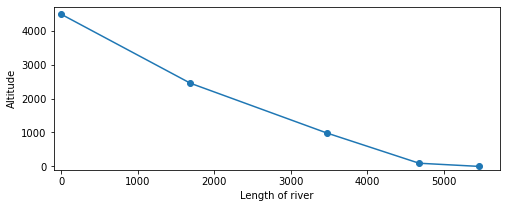

In [2]:
features = pd.read_csv("../data/hydrology/river_features.csv")
features.columns = [k.strip() for k in features.columns]
length = features['length'].cumsum().values.tolist()
length.insert(0, 0)
fall = features['fall'].sort_index(ascending=False).cumsum().sort_index(ascending=True).values.tolist()
fall.insert(4, 0)

# plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(length, fall, "-o")
ax.set_xlim(-100, np.max(length)*1.05)
ax.set_ylim(-100, np.max(fall)*1.05)
ax.set_xlabel("Length of river")
ax.set_ylabel("Altitude")
# ax.annotate()
plt.show();

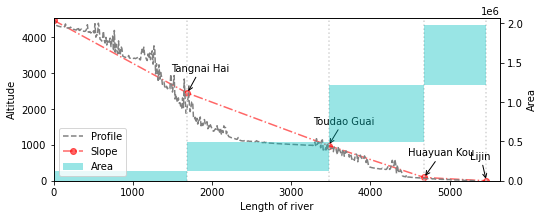

In [21]:
# 处理高程数据
from tools.processing import dbf_data_list, pd_read_dbf

altitude = pd_read_dbf('../data/hydrology/altitude_points_along_yr/altitude_points.dbf', usecols=['Shape_Leng', 'RASTERVALU'])
altitude['Shape_Leng'] /= 1000  # 单位将 米 转化为 千米
# altitude['RASTERVALU'] /= 1000  # 高程单位转化为千米
# 485号点开始，有几个数据是错误的位置，给他们标好顺序
reindex = list(np.arange(len(altitude) - 485, len(altitude))) + list(np.arange(len(altitude) - 485))
altitude.index = reindex 
altitude.sort_index(inplace=True)
# 将河流全长，按照点的数量进行划分
altitude['Shape_Leng'] = np.linspace(0, altitude['Shape_Leng'].iloc[0], len(altitude))

# 处理流域集水面积数据
stations = pd.read_csv('../data/hydrology/hydro_stations.csv')

# 作图
fig, ax = plt.subplots(figsize=(8, 3))

slope = ax.plot(length, fall, "-.o", color='red', alpha=0.6, label='Slope')
profile = ax.plot(altitude['Shape_Leng'], altitude['RASTERVALU'], '--', color='gray', label='Profile')
for i, x in enumerate(length):
    ax.axvline(x, ls=":", color='lightgray')

ax2 = ax.twinx()
bottom = 0
for i in range(4):
    height = stations['catchment area'][i]
    width = length[i+1]-length[i]
    center = length[i] + width/2
    area = ax2.bar(x=length[i], align='edge', width=width, bottom=bottom, height=height, color='c', alpha=.4, label='Area')
    bottom += height
    ax.annotate(stations['station'][i],
            xy=(length[i+1], fall[i+1]), xycoords='data',
            xytext=(length[i+1]-200, fall[i+1]+600), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle='arc3'))

ax.set_xlim(altitude['Shape_Leng'].min(), altitude['Shape_Leng'].max()*1.06)
ax.set_ylim(altitude['RASTERVALU'].min(), altitude['RASTERVALU'].max())
ax.set_xlabel("Length of river")
ax.set_ylabel("Altitude")
ax2.set_ylabel("Area")
plt.legend(handles=profile + slope + [area], loc='lower left')
# 添加指示线，控制站名称

plt.savefig('../figures/supplementary_information/slope.jpg', dpi=300)
plt.show();

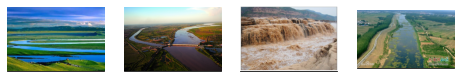

In [15]:
import matplotlib.patches as patches
import matplotlib.cbook as cbook
import matplotlib.image as imgplt

fig, axs = plt.subplots(1, 4, figsize=(8, 3))
for i, region in enumerate(['source', 'upper', 'middle', 'lower']):
    ax = axs[i]
    image = imgplt.imread('../figures/supplementary_information/{}_region.jpg'.format(region))
    im = ax.imshow(image)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    

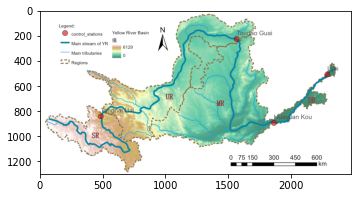

In [16]:
yr_map = imgplt.imread('../figures/supplementary_information/map.jpg')
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(yr_map)

# 经济、人口、水资源量和水资源消耗量

In [24]:
# 经济


2.65